# Análisis Predictivo 

**Nota:** Por favor leer el archivo vaepReadMe.md para obtener más información incluyendo el orden en que se deben ejecutar los scripts

El siguiente script tiene por objetivo utilizar el índice VAEP para predecir el resultado de los partidos (si el equipo ganará o no).

Se utilizará el valor acumulado de los índices VAEP total ofensivo y defensivo, a favor y en contra en los partidos anteriores para predecir el resultado del próximo partido.


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("Vaep-result-pred")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [3]:
import random
import numpy as np

#set seed
random.seed(1234)
np.random.seed(1234)

### Preparacion de los datos

A continuacion se calculan los indices acumulados para ambos equipos por partido

In [4]:
import pandas as pd

In [5]:
parquetData = '/dataset/vaep/parquet/match_events.parquet'

In [6]:
df_parquet = spark.read.parquet(parquetData)

In [7]:
df_parquet.createOrReplaceTempView("eventsAnalysis")

In [8]:
# Esta query calcula el puntaje VAEP ofensivo, defensivo y total por equipo por partido

query='''

SELECT game_id, team_id, short_team_name, sum(offensive_value) as offensiveVAEP, sum(defensive_value) as defensiveVAEP, sum(vaep_value) as totalVAEP
FROM eventsAnalysis
group by game_id, team_id, short_team_name

'''

In [9]:
df_parquet = spark.sql(query)
df_parquet.createOrReplaceTempView("vaepPerGame")
df_parquet.show(5)

+-------+-------+--------------------+------------------+--------------------+------------------+
|game_id|team_id|     short_team_name|     offensiveVAEP|       defensiveVAEP|         totalVAEP|
+-------+-------+--------------------+------------------+--------------------+------------------+
|2499850|   1609|             Arsenal| 5.800531201530248|-8.23160109575837...| 5.799708048347384|
|2576059|   3219|           Benevento|1.7643836359493434| 0.10706544801359996|1.8714490730781108|
|2576044|   3161|      Internazionale|0.5785705242305994|  0.3317085389280692|0.9102790635079145|
|2500065|  10531|        Swansea City|0.5273028190713376|  0.2623006572248414|0.7896034918958321|
|2500024|   1651|Brighton & Hove A...| 1.321480500861071| 0.36449467175407335|1.6859752273885533|
+-------+-------+--------------------+------------------+--------------------+------------------+
only showing top 5 rows



In [10]:
df_parquet.count()

2280

In [11]:
parquetData = '/dataset/vaep/parquet/matches.parquet'

In [12]:
df_parquet = spark.read.parquet(parquetData)

In [13]:
df_parquet.createOrReplaceTempView("matches")

In [14]:
# Esta query obtiene el resultado de cada partido, los equipos que lo jugaron, la fecha del mismo y crea la variable team1winflag
# que toma el valor de 1 si el equipo 1 ganó o 0 si empató o perdió. Esta será la variable a predecir.

query='''


SELECT competitionid, wyId as game_id ,team1_teamId, team1_side , team2_teamId,
case when winner=team1_teamId then 1 else 0 END as team1winflag,
dateutc
FROM matches
Order by dateutc desc

'''

In [15]:
df_parquet = spark.sql(query)
df_parquet.createOrReplaceTempView("matchResults")
df_parquet.show(5)

+-------------+-------+------------+----------+------------+------------+-------------------+
|competitionid|game_id|team1_teamId|team1_side|team2_teamId|team1winflag|            dateutc|
+-------------+-------+------------+----------+------------+------------+-------------------+
|          524|2576336|        3158|      away|        3315|           1|2018-05-20 18:45:00|
|          795|2565922|         676|      home|         687|           1|2018-05-20 18:45:00|
|          524|2576335|        3162|      home|        3161|           0|2018-05-20 18:45:00|
|          795|2565925|         679|      home|         701|           0|2018-05-20 16:30:00|
|          524|2576330|        3165|      home|        3219|           1|2018-05-20 16:00:00|
+-------------+-------+------------+----------+------------+------------+-------------------+
only showing top 5 rows



In [16]:
df_parquet.count()

1140

In [17]:
# Esta query obtiene el resultado del partido, los valores VAEP para cada partido y la fecha en que se jugó.

query='''

select  competitionid, tableWithTeam1.game_id ,team1_teamId, team1_side , team1_name, team1_offensiveVAEP,
team1_defensiveVAEP, team1_totalVAEP, 

team2_teamId, short_team_name as team2_name, offensiveVAEP as team2_offensiveVAEP,
defensiveVAEP as team2_defensiveVAEP, totalVAEP as team2_totalVAEP, 

team1winflag, dateutc

from
(
select competitionid, matchResults.game_id ,team1_teamId, team1_side , short_team_name as team1_name, offensiveVAEP as team1_offensiveVAEP,
defensiveVAEP as team1_defensiveVAEP, totalVAEP as team1_totalVAEP, team2_teamId, team1winflag, dateutc
FROM matchResults join vaepPerGame on 
(matchResults.game_id=vaepPerGame.game_id and matchResults.team1_teamId=vaepPerGame.team_id)
) as tableWithTeam1

join vaepPerGame on 
(tableWithTeam1.game_id=vaepPerGame.game_id and tableWithTeam1.team2_teamId=vaepPerGame.team_id)

order by dateutc asc
'''

In [18]:
matches = spark.sql(query)
matches.show(5)

+-------------+-------+------------+----------+--------------+-------------------+--------------------+------------------+------------+-----------------+-------------------+--------------------+------------------+------------+-------------------+
|competitionid|game_id|team1_teamId|team1_side|    team1_name|team1_offensiveVAEP| team1_defensiveVAEP|   team1_totalVAEP|team2_teamId|       team2_name|team2_offensiveVAEP| team2_defensiveVAEP|   team2_totalVAEP|team1winflag|            dateutc|
+-------------+-------+------------+----------+--------------+-------------------+--------------------+------------------+------------+-----------------+-------------------+--------------------+------------------+------------+-------------------+
|          364|2499719|        1609|      home|       Arsenal|  4.670027377083898| 0.11731985094957054| 4.787347314530052|        1631|   Leicester City| 3.7192057595821097| -0.3971957864705473|3.3220099792815745|           1|2017-08-11 18:45:00|
|          3

In [19]:
matches.count()

1140

In [20]:
#Se agregan 2 features nuevas con la diferencia del vaep total a favor del team 1 y a favor del team 2 para cada partido

matches=matches.withColumn("VaepDiffTeam1",(matches['team1_totalVAEP']-matches['team2_totalVAEP']))
matches=matches.withColumn("VaepDiffTeam2",(matches['team2_totalVAEP']-matches['team1_totalVAEP']))

In [21]:
matches.select('team1_totalVAEP','team2_totalVAEP','VaepDiffTeam1', 'VaepDiffTeam2').show(5)

+------------------+------------------+-------------------+-------------------+
|   team1_totalVAEP|   team2_totalVAEP|      VaepDiffTeam1|      VaepDiffTeam2|
+------------------+------------------+-------------------+-------------------+
| 4.787347314530052|3.3220099792815745| 1.4653373352484778|-1.4653373352484778|
|3.8164702638750896| 4.284398326068185|-0.4679280621930957| 0.4679280621930957|
|0.9094714188249782|2.6136321051744744|-1.7041606863494962| 1.7041606863494962|
|1.1590999013278633| 2.141056228079833|-0.9819563267519698| 0.9819563267519698|
| 0.328015681123361|0.9065207471139729|-0.5785050659906119| 0.5785050659906119|
+------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [22]:
matches.createOrReplaceTempView("matchData")

In [23]:
# Esta query calcula los valores VAEP acumulados por partido (incluyendo el del partido a analizar que 
# se resta más adelante) para el team1 únicamente

query='''

select teamID as team1ID, game_id, sum(offensiveVAEP) as sum_off_vaep_team1, sum(defensiveVAEP) as sum_def_vaep_team1,
sum(totalVAEP) as sum_tot_vaep_team1,sum(VaepDiff) as sum_vaep_diff_team1
from
(
(
SELECT matchData1.team1_teamId as teamID, matchData1.dateutc as row_num_index, matchData2.dateutc as other_row_num,
matchData1.game_id, matchData2.game_id as previous_game_id, matchData2.team1_offensiveVAEP as offensiveVAEP, 
matchData2.team1_defensiveVAEP as defensiveVAEP,matchData2.team1_totalVAEP as totalVAEP,
matchData2.VaepDiffTeam1 as VaepDiff

FROM matchData as matchData1 JOIN matchData as matchData2
on ((matchData1.dateutc >= matchData2.dateutc) and 
(matchData1.team1_teamId=matchData2.team1_teamId ))
order by matchData1.team1_teamId, matchData1.dateutc, matchData2.dateutc
)

UNION ALL

(
SELECT matchData1.team1_teamId as teamID, matchData1.dateutc as row_num_index, matchData2.dateutc as other_row_num,
matchData1.game_id, matchData2.game_id as previous_game_id, matchData2.team2_offensiveVAEP as offensiveVAEP, 
matchData2.team2_defensiveVAEP as defensiveVAEP,matchData2.team2_totalVAEP as totalVAEP,
matchData2.VaepDiffTeam2 as VaepDiff

FROM matchData as matchData1 JOIN matchData as matchData2
on ((matchData1.dateutc >= matchData2.dateutc) and 
(matchData1.team1_teamId=matchData2.team2_teamId ))
order by matchData1.team1_teamId, matchData1.dateutc, matchData2.dateutc
)
)
group by teamID, game_id
'''

In [24]:
team1Data = spark.sql(query)
team1Data.show(10)

+-------+-------+------------------+-------------------+------------------+-------------------+
|team1ID|game_id|sum_off_vaep_team1| sum_def_vaep_team1|sum_tot_vaep_team1|sum_vaep_diff_team1|
+-------+-------+------------------+-------------------+------------------+-------------------+
|   1644|2500087|  70.4470175447641| 1.9129082587605808| 72.35992552834432| -20.18629422673621|
|   1644|2500093| 71.37924566707807| 1.9048662013665307| 73.28411157970186|-21.084896127871616|
|   1646|2499721|3.6477766492171213|  0.590171214309521|4.2379479093360715| 0.7239726117695682|
|   1646|2499730| 4.780997149995528| 0.5169456836301833| 5.297942872683052|0.15782827039947733|
|   1646|2499746| 6.652883380185813| 0.5626359689049423| 7.215519345074426|0.28462251159362495|
|   1646|2499751| 8.256027959519997| 0.5087594220531173|   8.7647873814567| 0.4632746485294774|
|   1646|2499771|10.958894129144028|  0.621454002102837|11.580348118848633|0.26598465035203844|
|   1646|2499832|22.007779969015246|0.41

In [25]:
team1Data.count()

1140

In [26]:
# Esta query calcula los valores VAEP acumulados por partido (incluyendo el del partido a analizar que 
# se resta más adelante) para el team2 únicamente


query='''

select teamID as team2ID, game_id, sum(offensiveVAEP) as sum_off_vaep_team2, sum(defensiveVAEP) as sum_def_vaep_team2,
sum(totalVAEP) as sum_tot_vaep_team2,sum(VaepDiff) as sum_vaep_diff_team2
from
(
(
SELECT matchData1.team2_teamId as teamID, matchData1.dateutc as row_num_index, matchData2.dateutc as other_row_num,
matchData1.game_id, matchData2.game_id as previous_game_id, matchData2.team1_offensiveVAEP as offensiveVAEP, 
matchData2.team1_defensiveVAEP as defensiveVAEP,matchData2.team1_totalVAEP as totalVAEP,
matchData2.VaepDiffTeam1 as VaepDiff

FROM matchData as matchData1 JOIN matchData as matchData2
on ((matchData1.dateutc >= matchData2.dateutc) and 
(matchData1.team2_teamId=matchData2.team1_teamId ))
order by matchData1.team2_teamId, matchData1.dateutc, matchData2.dateutc
)

UNION ALL

(
SELECT matchData1.team2_teamId as teamID, matchData1.dateutc as row_num_index, matchData2.dateutc as other_row_num,
matchData1.game_id, matchData2.game_id as previous_game_id, matchData2.team2_offensiveVAEP as offensiveVAEP, 
matchData2.team2_defensiveVAEP as defensiveVAEP,matchData2.team2_totalVAEP as totalVAEP,
matchData2.VaepDiffTeam2 as VaepDiff

FROM matchData as matchData1 JOIN matchData as matchData2
on ((matchData1.dateutc >= matchData2.dateutc) and 
(matchData1.team2_teamId=matchData2.team2_teamId ))
order by matchData1.team2_teamId, matchData1.dateutc, matchData2.dateutc
)
)
group by teamID, game_id
'''

In [27]:
team2Data = spark.sql(query)
team2Data.show(10)

+-------+-------+------------------+-------------------+------------------+-------------------+
|team2ID|game_id|sum_off_vaep_team2| sum_def_vaep_team2|sum_tot_vaep_team2|sum_vaep_diff_team2|
+-------+-------+------------------+-------------------+------------------+-------------------+
|   1625|2499954|  84.4300286991056|  2.169538874470163| 86.59956743102202|   50.1315621181825|
|   1625|2500004|101.30843974102754| 2.2022605111123994| 103.5107000777466|  61.85455818642777|
|   1625|2500085|122.47292446461506| 2.4651723270653747|124.93809646193085|  71.19957275438037|
|   1627|2499868|25.552723918983247|  3.017375025548972|  28.5700991199119|  -6.45581169833531|
|   1627|2500090| 63.48440709657734|  5.842754062090535| 69.32716113136848| -23.20337752083651|
|   1628|2499751| 4.753765938570723|-0.6082334127859212| 4.145532526716124| -4.413750352396164|
|   1628|2499941| 37.43408431223361| 1.0494996983907185| 38.48358404356986|-12.808104421623284|
|   1631|2499864| 28.67676688177744| 1.6

In [28]:
team2Data.count()

1140

In [29]:
team1Data.createOrReplaceTempView("Team1Data")
team2Data.createOrReplaceTempView("Team2Data")

In [30]:
# Esta query calcula los valores VAEP acumulados por partido para ambos equipos teniendo en cuenta solo los partidos 
# anteriores y se incluyen los resultados del partido. Tambien se numeran los partidos segun la fecha en que 
# se jugaron (row_num)


query='''

select ROW_NUMBER() OVER (ORDER BY dateutc asc) row_num, dateutc , competitionid, matchdata.game_id, 

team1_teamId, team1_name,
(sum_tot_vaep_team1 - team1_totalVAEP) as team1_totalVaepAccum, 
(sum_off_vaep_team1 - team1_offensiveVAEP) as team1_offVaepAccum, 
(sum_def_vaep_team1 - team1_defensiveVAEP) as team1_defVaepAccum,
(sum_vaep_diff_team1 - VaepDiffTeam1) as team1_againstVaepAccum,

team2_teamId, team2_name,
(sum_tot_vaep_team2 - team2_totalVAEP) as team2_totalVaepAccum, 
(sum_off_vaep_team2 - team2_offensiveVAEP) as team2_offVaepAccum, 
(sum_def_vaep_team2 - team2_defensiveVAEP) as team2_defVaepAccum,
(sum_vaep_diff_team2 - VaepDiffTeam2) as team2_againstVaepAccum,

team1_side,team1winflag

from matchData join Team1Data on
((matchData.team1_teamId=Team1Data.team1ID) and (matchData.game_id=Team1Data.game_id))
join Team2Data on
((matchData.team2_teamId=Team2Data.team2ID) and (matchData.game_id=Team2Data.game_id))

order by dateutc asc
'''

In [31]:
fullMatchData = spark.sql(query)
fullMatchData.show(10)

+-------+-------------------+-------------+-------+------------+--------------------+--------------------+------------------+------------------+----------------------+------------+--------------------+--------------------+------------------+------------------+----------------------+----------+------------+
|row_num|            dateutc|competitionid|game_id|team1_teamId|          team1_name|team1_totalVaepAccum|team1_offVaepAccum|team1_defVaepAccum|team1_againstVaepAccum|team2_teamId|          team2_name|team2_totalVaepAccum|team2_offVaepAccum|team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|
+-------+-------------------+-------------+-------+------------+--------------------+--------------------+------------------+------------------+----------------------+------------+--------------------+--------------------+------------------+------------------+----------------------+----------+------------+
|      1|2017-08-11 18:45:00|          364|2499719|        1609|            

In [32]:
fullMatchData.count()

1140

### Feature engineering 

Aqui se crean features adicionales relacionando los valores VAEP acumulados de los dos equipos mediante restas y divisiones.

In [33]:
fullMatchData=fullMatchData.withColumn("pythTeam1",fullMatchData['team1_totalVaepAccum']**2/(fullMatchData['team1_totalVaepAccum']**2 + fullMatchData['team1_againstVaepAccum']**2))
fullMatchData=fullMatchData.withColumn("pythTeam2",fullMatchData['team2_totalVaepAccum']**2/(fullMatchData['team2_totalVaepAccum']**2 + fullMatchData['team2_againstVaepAccum']**2))
fullMatchData=fullMatchData.withColumn("pythdiff",fullMatchData['pythTeam1']-fullMatchData['pythTeam2'])
fullMatchData=fullMatchData.withColumn("pythdiv",fullMatchData['pythTeam1']/fullMatchData['pythTeam2'])

In [34]:
fullMatchData=fullMatchData.withColumn("totalVaepDiv",fullMatchData['team1_totalVaepAccum']/fullMatchData['team2_totalVaepAccum'])
fullMatchData=fullMatchData.withColumn("totalVaepDiff",fullMatchData['team1_totalVaepAccum']-fullMatchData['team2_totalVaepAccum'])

fullMatchData=fullMatchData.withColumn("OffensiveVaepDiv",fullMatchData['team1_offVaepAccum']/fullMatchData['team2_offVaepAccum'])
fullMatchData=fullMatchData.withColumn("OffensiveVaepDiff",fullMatchData['team1_offVaepAccum']-fullMatchData['team2_offVaepAccum'])

fullMatchData=fullMatchData.withColumn("totalDefVaepDiv",fullMatchData['team1_defVaepAccum']/fullMatchData['team2_defVaepAccum'])
fullMatchData=fullMatchData.withColumn("totalDefVaepDiff",fullMatchData['team1_defVaepAccum']-fullMatchData['team2_defVaepAccum'])

fullMatchData=fullMatchData.withColumn("totalVaepAgainstDiv",fullMatchData['team1_againstVaepAccum']/fullMatchData['team2_againstVaepAccum'])
fullMatchData=fullMatchData.withColumn("totalVaepAgainstDiff",fullMatchData['team1_againstVaepAccum']-fullMatchData['team2_againstVaepAccum'])




### Eliminación de filas y columnas innecesarias

Se eliminan los datos de los primeros partidos al tener poca informacion relevante (valores acumulados nulos o muy pequeños), las filas con valores nulos o NAN y las columnas que no serán utilizadas para el análisis.

In [35]:
fullMatchData.count()

1140

In [36]:
# Se agrega una columna nueva con el número de columna y se eliminan los primeros 110 partidos
# La columna no se elimina posteriormente para que el algoritmo tenga noción de cuáles son los partidos más y menos
# recientes.

#from pyspark.sql.functions import row_number,lit
#from pyspark.sql.window import Window

#w = Window().orderBy(lit('dateutc'))
#fullMatchData = fullMatchData.withColumn("row_num", row_number().over(w))

numberOfColumnsToDrop=140
fullMatchData=fullMatchData.where(fullMatchData['row_num']>numberOfColumnsToDrop)

fullMatchData.show()

+-------+-------------------+-------------+-------+------------+-------------------+--------------------+------------------+--------------------+----------------------+------------+-----------------+--------------------+------------------+--------------------+----------------------+----------+------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|row_num|            dateutc|competitionid|game_id|team1_teamId|         team1_name|team1_totalVaepAccum|team1_offVaepAccum|  team1_defVaepAccum|team1_againstVaepAccum|team2_teamId|       team2_name|team2_totalVaepAccum|team2_offVaepAccum|  team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|         pythTeam1|          pythTeam2|            pythdiff|           pythdiv|       totalVaepDiv|      totalVaepDiff|   OffensiveVaepDiv|  Of

In [37]:
fullMatchData.count()

1000

In [38]:
fullMatchData.toPandas()

,row_num,dateutc,competitionid,game_id,team1_teamId,team1_name,team1_totalVaepAccum,team1_offVaepAccum,team1_defVaepAccum,team1_againstVaepAccum,...,pythdiff,pythdiv,totalVaepDiv,totalVaepDiff,OffensiveVaepDiv,OffensiveVaepDiff,totalDefVaepDiv,totalDefVaepDiff,totalVaepAgainstDiv,totalVaepAgainstDiff
0,141,2017-09-20 18:45:00,524,2575999,3172,Atalanta,6.702192,6.153856,0.548335,-2.261563,...,0.489187,2.197260,1.701839,2.763985,1.669254,2.467266,2.179253,0.296719,0.477319,2.476490
1,142,2017-09-20 18:45:00,524,2576006,3162,Lazio,11.951341,11.219702,0.731639,4.150067,...,0.234607,1.356660,0.770574,-3.558319,0.727852,-4.195112,7.713975,0.636793,0.370978,-7.036758
2,143,2017-09-20 18:45:00,524,2576007,3157,Milan,10.930023,10.610889,0.319134,2.185074,...,-0.024478,0.975175,1.371880,2.962837,1.521232,3.635696,0.321710,-0.672859,-2.305678,3.132766
3,144,2017-09-20 19:00:00,795,2565594,677,Deportivo La Coruña,7.766739,7.362446,0.404293,-5.438777,...,0.416253,2.634151,2.004869,3.892800,2.303103,4.165695,0.597017,-0.272895,0.820770,1.187656
4,145,2017-09-20 20:00:00,795,2565596,675,Real Madrid,12.142318,11.395342,0.746976,4.139777,...,-0.083090,0.915124,1.480747,3.942189,1.491513,3.755217,1.333876,0.186972,-3.443259,5.342062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1136,2018-05-20 16:00:00,524,2576330,3165,Chievo,69.313993,63.348680,5.965312,-13.959674,...,0.193355,1.251874,1.017557,1.195967,1.051508,3.103138,0.757742,-1.907172,0.372514,23.514584
996,1137,2018-05-20 16:30:00,795,2565925,679,Atlético Madrid,90.463882,84.685144,5.778737,30.032876,...,-0.099235,0.900761,1.241424,17.592800,1.169252,12.258390,13.005567,5.334410,-65.812037,30.489219
997,1138,2018-05-20 18:45:00,524,2576335,3162,Lazio,111.339853,105.522377,5.817476,38.481203,...,0.009466,1.010711,1.221079,20.158332,1.225433,19.412076,1.147155,0.746257,1.164055,5.423319
998,1139,2018-05-20 18:45:00,524,2576336,3158,Roma,86.357842,84.069288,2.288554,27.321400,...,0.193709,1.270806,1.531218,29.959691,1.649194,33.093313,0.422073,-3.133621,-0.767882,62.901617


In [39]:
# Se eliminan las columnas que no se utilizarán para el análisis

df=fullMatchData.drop('competitionid','game_id','team1_teamId','team1_name','team2_teamId','team2_name','dateutc')

In [40]:
# Estas son las features finales antes del análisis

df.toPandas()

,row_num,team1_totalVaepAccum,team1_offVaepAccum,team1_defVaepAccum,team1_againstVaepAccum,team2_totalVaepAccum,team2_offVaepAccum,team2_defVaepAccum,team2_againstVaepAccum,team1_side,...,pythdiff,pythdiv,totalVaepDiv,totalVaepDiff,OffensiveVaepDiv,OffensiveVaepDiff,totalDefVaepDiv,totalDefVaepDiff,totalVaepAgainstDiv,totalVaepAgainstDiff
0,141,7.005220,6.595284,0.409936,-1.127720,6.225714,5.381333,0.844381,-4.402305,away,...,0.308079,1.462122,1.125207,0.779506,1.225586,1.213951,0.485487,-0.434445,0.256166,3.274585
1,142,7.311395,7.693820,-0.382425,0.774307,4.334536,3.222659,1.111877,-9.092477,away,...,0.803733,5.340373,1.686777,2.976859,2.387414,4.471161,-0.343946,-1.494302,-0.085159,9.866784
2,143,6.702192,6.153856,0.548335,-2.261563,3.938206,3.686590,0.251616,-4.738053,home,...,0.489187,2.197260,1.701839,2.763985,1.669254,2.467266,2.179253,0.296719,0.477319,2.476490
3,144,7.766739,7.362446,0.404293,-5.438777,3.873939,3.196751,0.677187,-6.626433,home,...,0.416253,2.634151,2.004869,3.892800,2.303103,4.165695,0.597017,-0.272895,0.820770,1.187656
4,145,12.142318,11.395342,0.746976,4.139777,8.200129,7.640125,0.560004,-1.202284,home,...,-0.083090,0.915124,1.480747,3.942189,1.491513,3.755217,1.333876,0.186972,-3.443259,5.342062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1136,79.067737,80.202457,-1.134720,-4.809436,64.610715,60.651563,3.959153,-17.091040,away,...,0.061710,1.066028,1.223756,14.457021,1.322348,19.550894,-0.286607,-5.093873,0.281401,12.281604
996,1137,90.463882,84.685144,5.778737,30.032876,72.871082,72.426754,0.444328,-0.456343,home,...,-0.099235,0.900761,1.241424,17.592800,1.169252,12.258390,13.005567,5.334410,-65.812037,30.489219
997,1138,131.912998,129.204383,2.708616,63.698653,95.855389,93.810651,2.044739,10.269121,home,...,-0.177739,0.820221,1.376167,36.057609,1.377289,35.393732,1.324675,0.663876,6.202931,53.429532
998,1139,111.339853,105.522377,5.817476,38.481203,91.181520,86.110300,5.071220,33.057884,home,...,0.009466,1.010711,1.221079,20.158332,1.225433,19.412076,1.147155,0.746257,1.164055,5.423319


In [41]:
# Se elimnan las filas con NANs y NuLLs

df=df.na.drop("any")

In [42]:
# Asi queda el dataframe final

df.toPandas()

,row_num,team1_totalVaepAccum,team1_offVaepAccum,team1_defVaepAccum,team1_againstVaepAccum,team2_totalVaepAccum,team2_offVaepAccum,team2_defVaepAccum,team2_againstVaepAccum,team1_side,...,pythdiff,pythdiv,totalVaepDiv,totalVaepDiff,OffensiveVaepDiv,OffensiveVaepDiff,totalDefVaepDiv,totalDefVaepDiff,totalVaepAgainstDiv,totalVaepAgainstDiff
0,141,7.005220,6.595284,0.409936,-1.127720,6.225714,5.381333,0.844381,-4.402305,away,...,0.308079,1.462122,1.125207,0.779506,1.225586,1.213951,0.485487,-0.434445,0.256166,3.274585
1,142,7.311395,7.693820,-0.382425,0.774307,4.334536,3.222659,1.111877,-9.092477,away,...,0.803733,5.340373,1.686777,2.976859,2.387414,4.471161,-0.343946,-1.494302,-0.085159,9.866784
2,143,6.702192,6.153856,0.548335,-2.261563,3.938206,3.686590,0.251616,-4.738053,home,...,0.489187,2.197260,1.701839,2.763985,1.669254,2.467266,2.179253,0.296719,0.477319,2.476490
3,144,7.766739,7.362446,0.404293,-5.438777,3.873939,3.196751,0.677187,-6.626433,home,...,0.416253,2.634151,2.004869,3.892800,2.303103,4.165695,0.597017,-0.272895,0.820770,1.187656
4,145,12.142318,11.395342,0.746976,4.139777,8.200129,7.640125,0.560004,-1.202284,home,...,-0.083090,0.915124,1.480747,3.942189,1.491513,3.755217,1.333876,0.186972,-3.443259,5.342062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1136,79.067737,80.202457,-1.134720,-4.809436,64.610715,60.651563,3.959153,-17.091040,away,...,0.061710,1.066028,1.223756,14.457021,1.322348,19.550894,-0.286607,-5.093873,0.281401,12.281604
996,1137,90.463882,84.685144,5.778737,30.032876,72.871082,72.426754,0.444328,-0.456343,home,...,-0.099235,0.900761,1.241424,17.592800,1.169252,12.258390,13.005567,5.334410,-65.812037,30.489219
997,1138,131.912998,129.204383,2.708616,63.698653,95.855389,93.810651,2.044739,10.269121,home,...,-0.177739,0.820221,1.376167,36.057609,1.377289,35.393732,1.324675,0.663876,6.202931,53.429532
998,1139,111.339853,105.522377,5.817476,38.481203,91.181520,86.110300,5.071220,33.057884,home,...,0.009466,1.010711,1.221079,20.158332,1.225433,19.412076,1.147155,0.746257,1.164055,5.423319


In [43]:
df.toPandas().isna().sum() 

row_num                   0
team1_totalVaepAccum      0
team1_offVaepAccum        0
team1_defVaepAccum        0
team1_againstVaepAccum    0
team2_totalVaepAccum      0
team2_offVaepAccum        0
team2_defVaepAccum        0
team2_againstVaepAccum    0
team1_side                0
team1winflag              0
pythTeam1                 0
pythTeam2                 0
pythdiff                  0
pythdiv                   0
totalVaepDiv              0
totalVaepDiff             0
OffensiveVaepDiv          0
OffensiveVaepDiff         0
totalDefVaepDiv           0
totalDefVaepDiff          0
totalVaepAgainstDiv       0
totalVaepAgainstDiff      0
dtype: int64

In [44]:
df.toPandas().isnull().sum() 

row_num                   0
team1_totalVaepAccum      0
team1_offVaepAccum        0
team1_defVaepAccum        0
team1_againstVaepAccum    0
team2_totalVaepAccum      0
team2_offVaepAccum        0
team2_defVaepAccum        0
team2_againstVaepAccum    0
team1_side                0
team1winflag              0
pythTeam1                 0
pythTeam2                 0
pythdiff                  0
pythdiv                   0
totalVaepDiv              0
totalVaepDiff             0
OffensiveVaepDiv          0
OffensiveVaepDiff         0
totalDefVaepDiv           0
totalDefVaepDiff          0
totalVaepAgainstDiv       0
totalVaepAgainstDiff      0
dtype: int64

### Estimación de victoria con el algoritmo random forest (simple)

En la siguiente sección se utiliza el algoritmo random forest para predecir si el equipo 1 ganará o no en base a las features obtenidas en la sección anterior sin optimización de hiperparametros.

In [45]:
# Se protege la variable a estimar

PROTECTED_COLS= ['team1winflag']

In [46]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in df.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [47]:
# Se dividen las columnas entre las categóricas y las numéricas
# De aquí en más se preparan las variables para usar el algoritmo de random forest

num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
cat_cols, num_cols# ,df.columns

(['team1_side'],
 ['row_num',
  'team1_totalVaepAccum',
  'team1_offVaepAccum',
  'team1_defVaepAccum',
  'team1_againstVaepAccum',
  'team2_totalVaepAccum',
  'team2_offVaepAccum',
  'team2_defVaepAccum',
  'team2_againstVaepAccum',
  'pythTeam1',
  'pythTeam2',
  'pythdiff',
  'pythdiv',
  'totalVaepDiv',
  'totalVaepDiff',
  'OffensiveVaepDiv',
  'OffensiveVaepDiff',
  'totalDefVaepDiv',
  'totalDefVaepDiff',
  'totalVaepAgainstDiv',
  'totalVaepAgainstDiff'])

In [48]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(df):
    cat_cols = _get_typed_cols(df, col_type='cat')
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in df.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
            df = indexer.transform(df)
    return df, encoded_cols

In [49]:
df, encoded_cols = _encode_categorical(df)
df.show(5)

+-------+--------------------+------------------+--------------------+----------------------+--------------------+------------------+------------------+----------------------+----------+------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------+
|row_num|team1_totalVaepAccum|team1_offVaepAccum|  team1_defVaepAccum|team1_againstVaepAccum|team2_totalVaepAccum|team2_offVaepAccum|team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|         pythTeam1|          pythTeam2|           pythdiff|           pythdiv|      totalVaepDiv|     totalVaepDiff|  OffensiveVaepDiv| OffensiveVaepDiff|    totalDefVaepDiv|   totalDefVaepDiff| totalVaepAgainstDiv|totalVaepAgainstDiff|team1_side_num|
+-------+--------------------+------------------+--------------------+----------------------+-----

In [50]:
feature_cols = num_cols + encoded_cols
feature_cols

['row_num',
 'team1_totalVaepAccum',
 'team1_offVaepAccum',
 'team1_defVaepAccum',
 'team1_againstVaepAccum',
 'team2_totalVaepAccum',
 'team2_offVaepAccum',
 'team2_defVaepAccum',
 'team2_againstVaepAccum',
 'pythTeam1',
 'pythTeam2',
 'pythdiff',
 'pythdiv',
 'totalVaepDiv',
 'totalVaepDiff',
 'OffensiveVaepDiv',
 'OffensiveVaepDiff',
 'totalDefVaepDiv',
 'totalDefVaepDiff',
 'totalVaepAgainstDiv',
 'totalVaepAgainstDiff',
 'team1_side_num']

In [51]:
from pyspark.ml.feature import OneHotEncoderEstimator

ohe_cols = [f'{c}_vec' for c in encoded_cols]
encoder = OneHotEncoderEstimator(inputCols=encoded_cols, outputCols=ohe_cols)
ohem = encoder.fit(df)
df = ohem.transform(df)
df.show(5)
feature_cols = num_cols + ohe_cols

+-------+--------------------+------------------+-------------------+----------------------+--------------------+------------------+-------------------+----------------------+----------+------------+------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------+------------------+
|row_num|team1_totalVaepAccum|team1_offVaepAccum| team1_defVaepAccum|team1_againstVaepAccum|team2_totalVaepAccum|team2_offVaepAccum| team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|         pythTeam1|          pythTeam2|            pythdiff|           pythdiv|      totalVaepDiv|     totalVaepDiff|  OffensiveVaepDiv| OffensiveVaepDiff|    totalDefVaepDiv|   totalDefVaepDiff|totalVaepAgainstDiv|totalVaepAgainstDiff|team1_side_num|team1_side_num_vec|
+-------+--------------------+------------------+-----------

In [52]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[141.0,7.00522005...|
|[142.0,7.31139540...|
|[143.0,6.70219169...|
|[144.0,7.76673879...|
|[145.0,12.1423177...|
+--------------------+
only showing top 5 rows



In [53]:
df.columns

['row_num',
 'team1_totalVaepAccum',
 'team1_offVaepAccum',
 'team1_defVaepAccum',
 'team1_againstVaepAccum',
 'team2_totalVaepAccum',
 'team2_offVaepAccum',
 'team2_defVaepAccum',
 'team2_againstVaepAccum',
 'team1_side',
 'team1winflag',
 'pythTeam1',
 'pythTeam2',
 'pythdiff',
 'pythdiv',
 'totalVaepDiv',
 'totalVaepDiff',
 'OffensiveVaepDiv',
 'OffensiveVaepDiff',
 'totalDefVaepDiv',
 'totalDefVaepDiff',
 'totalVaepAgainstDiv',
 'totalVaepAgainstDiff',
 'team1_side_num',
 'team1_side_num_vec',
 'features']

In [54]:
# Se divide el dataset en training y testing
# Nota: El resultado de randomspeed depende de como se ordenen los RDD, aunque tengas un seed fijo, hace el split diferente

train_data, test_data = df.randomSplit([0.7,0.3],seed=1234) 


In [55]:
# Se entrena el algoritmo de random forest

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='team1winflag', featuresCol='features', seed=1234)
rfm = rf.fit(train_data)
pred_df = rfm.transform(test_data)
pred_df.show(5)

+-------+--------------------+------------------+--------------------+----------------------+--------------------+------------------+-------------------+----------------------+----------+------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------+------------------+--------------------+--------------------+--------------------+----------+
|row_num|team1_totalVaepAccum|team1_offVaepAccum|  team1_defVaepAccum|team1_againstVaepAccum|team2_totalVaepAccum|team2_offVaepAccum| team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|         pythTeam1|          pythTeam2|            pythdiff|           pythdiv|       totalVaepDiv|      totalVaepDiff|   OffensiveVaepDiv| OffensiveVaepDiff|    totalDefVaepDiv|   totalDefVaepDiff| totalVaepAgainstDiv|totalVaepAgainstDiff|team1_side_

In [56]:
#Se calcula el área bajo la curva con el dataset de testeo

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='team1winflag', metricName='areaUnderROC')
evaluator.evaluate(pred_df)

0.723950966525224

In [57]:
#Se calcula el accuracy con el dataset de testeo

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='team1winflag', metricName='accuracy')
evaluator.evaluate(pred_df)

0.7509293680297398

In [58]:
rfm.featureImportances

SparseVector(22, {0: 0.0182, 1: 0.0259, 2: 0.0221, 3: 0.034, 4: 0.0445, 5: 0.0261, 6: 0.0323, 7: 0.0287, 8: 0.0815, 9: 0.0276, 10: 0.0311, 11: 0.0169, 12: 0.0229, 13: 0.0682, 14: 0.0657, 15: 0.12, 16: 0.1205, 17: 0.0398, 18: 0.0316, 19: 0.0238, 20: 0.0999, 21: 0.0187})

In [59]:
# Se calcula la importancia de las distintas features

from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, rfm.featureImportances[idx]) for idx, name in attrs if rfm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

,feature,importance
16,OffensiveVaepDiff,0.120525
15,OffensiveVaepDiv,0.119968
20,totalVaepAgainstDiff,0.099856
8,team2_againstVaepAccum,0.081459
13,totalVaepDiv,0.068221
14,totalVaepDiff,0.065712
4,team1_againstVaepAccum,0.044521
17,totalDefVaepDiv,0.039755
3,team1_defVaepAccum,0.033951
6,team2_offVaepAccum,0.032348


[Text(0, 0, 'OffensiveVaepDiff'),
 Text(0, 0, 'OffensiveVaepDiv'),
 Text(0, 0, 'totalVaepAgainstDiff'),
 Text(0, 0, 'team2_againstVaepAccum'),
 Text(0, 0, 'totalVaepDiv'),
 Text(0, 0, 'totalVaepDiff'),
 Text(0, 0, 'team1_againstVaepAccum'),
 Text(0, 0, 'totalDefVaepDiv'),
 Text(0, 0, 'team1_defVaepAccum'),
 Text(0, 0, 'team2_offVaepAccum'),
 Text(0, 0, 'totalDefVaepDiff'),
 Text(0, 0, 'pythTeam2'),
 Text(0, 0, 'team2_defVaepAccum'),
 Text(0, 0, 'pythTeam1'),
 Text(0, 0, 'team2_totalVaepAccum'),
 Text(0, 0, 'team1_totalVaepAccum'),
 Text(0, 0, 'totalVaepAgainstDiv'),
 Text(0, 0, 'pythdiv'),
 Text(0, 0, 'team1_offVaepAccum'),
 Text(0, 0, 'team1_side_num_vec_home')]

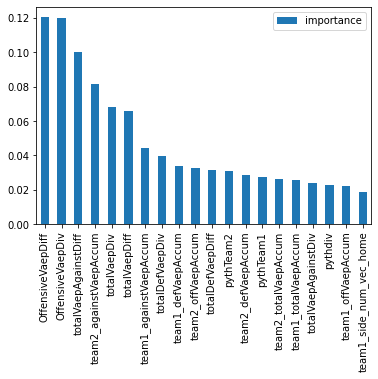

In [60]:
# Se grafica la importancia de las features

ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())

In [61]:
pred_df.createOrReplaceTempView("predicciones")

In [62]:
# Esta query calcula cuantas veces el algoritmo predijo correctamente y cuantas no

query='''

select team1winflag, prediction, count(*) as cantidad
from predicciones
group by team1winflag,prediction

'''

In [63]:
matrix = spark.sql(query)
matrix.show()

+------------+----------+--------+
|team1winflag|prediction|cantidad|
+------------+----------+--------+
|           0|       0.0|     140|
|           0|       1.0|      28|
|           1|       1.0|      49|
|           1|       0.0|      52|
+------------+----------+--------+



### Estimación de victoria con el algoritmo random forest (con estimación de hiperparametros)

En la siguiente sección se utiliza el algoritmo random forest para predecir si el equipo 1 ganará o no en base a las features obtenidas en la sección anterior con optimización de hiperparametros.

**Nota:** El entrenamiento del algoritmo toma su tiempo...

In [64]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [65]:
# Se definen los hiperparametros entre los cuales se iterará

paramGrid= ParamGridBuilder() \
.addGrid(rf.numTrees  , [20, 30, 50]) \
.addGrid(rf.maxBins   , [3, 5, 10]) \
.addGrid(rf.maxDepth, [4,6,8]) \
.build()

#  .addGrid(rf.numTrees  , [30, 50, 70]) \

#  .addGrid(rf.maxBins   , [5, 10, 20]) \

#  .addGrid(rf.maxDepth, [6,8,10]) \



In [66]:
# Defino el evaluator denuevo

evaluator = BinaryClassificationEvaluator(labelCol='team1winflag', metricName='areaUnderROC')

In [67]:
# Se crea la función de cross validation para buscar los hiperparametros óptimos

crossval = CrossValidator(estimator=rf,
                      estimatorParamMaps=paramGrid,
                      evaluator=evaluator,
                      numFolds=3)  

In [68]:
# Se entrena el algoritmo con todos los hiperparametros y se obtiene el óptimo

cvModel = crossval.fit(train_data)

In [69]:
# Se obtiene el dataset con las predicciones usando los datos de prueba

pred_df = cvModel.transform(test_data)
pred_df.show()

+-------+--------------------+------------------+--------------------+----------------------+--------------------+------------------+-------------------+----------------------+----------+------------+------------------+-------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+------------------+--------------------+--------------------+--------------------+----------+
|row_num|team1_totalVaepAccum|team1_offVaepAccum|  team1_defVaepAccum|team1_againstVaepAccum|team2_totalVaepAccum|team2_offVaepAccum| team2_defVaepAccum|team2_againstVaepAccum|team1_side|team1winflag|         pythTeam1|          pythTeam2|            pythdiff|           pythdiv|      totalVaepDiv|       totalVaepDiff|  OffensiveVaepDiv|   OffensiveVaepDiff|     totalDefVaepDiv|    totalDefVaepDiff| totalVaepAgainstDiv|totalVaepAgainstDiff|team1

In [70]:
# Se calcula el accuracy con los mejores hiperparametros

evaluator = MulticlassClassificationEvaluator(labelCol='team1winflag', metricName='accuracy')
evaluator.evaluate(pred_df)


0.6877323420074349

In [71]:
# Se calcula el areaUnderROC con los mejores hiperparametros

evaluator = BinaryClassificationEvaluator(labelCol='team1winflag', metricName='areaUnderROC')
evaluator.evaluate(pred_df)


0.7107496463932107

In [72]:
# Se imprime la importancia de cada feature

from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, rfm.featureImportances[idx]) for idx, name in attrs if rfm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)

feat_import.head(15)

,feature,importance
16,OffensiveVaepDiff,0.120525
15,OffensiveVaepDiv,0.119968
20,totalVaepAgainstDiff,0.099856
8,team2_againstVaepAccum,0.081459
13,totalVaepDiv,0.068221
14,totalVaepDiff,0.065712
4,team1_againstVaepAccum,0.044521
17,totalDefVaepDiv,0.039755
3,team1_defVaepAccum,0.033951
6,team2_offVaepAccum,0.032348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


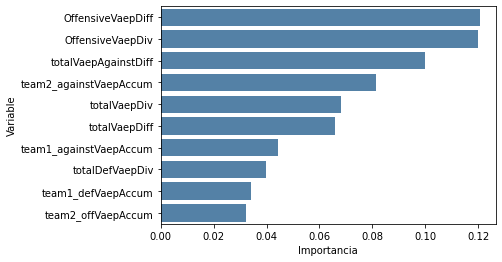

In [73]:
#Grafico para el informe en español

import seaborn as sns
mydata=feat_import.head(10)
mydata['Importancia']=mydata['importance']
mydata['Variable']=mydata['feature']

g=sns.barplot(y='Variable',x='Importancia',data=mydata, color='steelblue')
g.figure.savefig('/dataset/vaep/Images/RandomForestImportance.eps', format='eps', bbox_inches='tight')
g.figure.savefig('/dataset/vaep/Images/RandomForestImportance.png', dpi=1000, bbox_inches='tight')


[Text(0, 0, 'OffensiveVaepDiff'),
 Text(0, 0, 'OffensiveVaepDiv'),
 Text(0, 0, 'totalVaepAgainstDiff'),
 Text(0, 0, 'team2_againstVaepAccum'),
 Text(0, 0, 'totalVaepDiv'),
 Text(0, 0, 'totalVaepDiff'),
 Text(0, 0, 'team1_againstVaepAccum'),
 Text(0, 0, 'totalDefVaepDiv'),
 Text(0, 0, 'team1_defVaepAccum'),
 Text(0, 0, 'team2_offVaepAccum'),
 Text(0, 0, 'totalDefVaepDiff'),
 Text(0, 0, 'pythTeam2'),
 Text(0, 0, 'team2_defVaepAccum'),
 Text(0, 0, 'pythTeam1'),
 Text(0, 0, 'team2_totalVaepAccum'),
 Text(0, 0, 'team1_totalVaepAccum'),
 Text(0, 0, 'totalVaepAgainstDiv'),
 Text(0, 0, 'pythdiv'),
 Text(0, 0, 'team1_offVaepAccum'),
 Text(0, 0, 'team1_side_num_vec_home')]

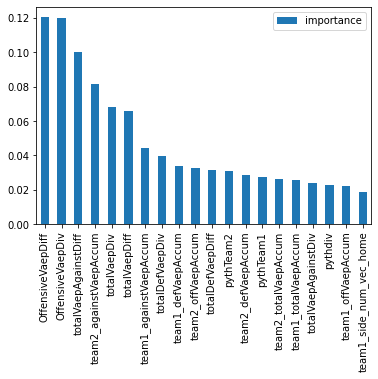

In [74]:
# Se grafica la importancia de cada feature

ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())

In [75]:
pred_df.createOrReplaceTempView("predicciones")

In [76]:
# Esta query Calcula cuantas veces el algoritmo predijo correctamente y cuantas no

query='''

select team1winflag, prediction, count(*) as cantidad
from predicciones
group by team1winflag,prediction

'''

In [77]:
matrix = spark.sql(query)
matrix.show()

+------------+----------+--------+
|team1winflag|prediction|cantidad|
+------------+----------+--------+
|           1|       1.0|      56|
|           0|       0.0|     150|
|           1|       0.0|      39|
|           0|       1.0|      24|
+------------+----------+--------+



In [78]:
#Imprimo el valor de los hiperparametros óptimos

import numpy as np

print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='RandomForestClassifier_14214ab3cb04', name='numTrees', doc='Number of trees to train (>= 1).'): 30, Param(parent='RandomForestClassifier_14214ab3cb04', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='RandomForestClassifier_14214ab3cb04', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8}


### Conclusión

El valor histórico de la evaluación VAEP de los equipos a enfrentarse resulta ser un buen estimador de si un equipo ganará o no un partido obteniéndose valores altos de AOC de accuracy 

In [79]:
spark.stop()
